# Final Project Submission

## Please fill out:
* Student name:
    - Carl Cook
* Student pace: 
    - Part-Time
* Scheduled project review date/time: 
    - June 10, 2020 4:30 pm
* Instructor name: 
    - James Irving
* Blog post URL:
    - https://katmandoone.github.io/apis_or_how_i_started_my_whole_project_over_again

# Questions

## What genres perform the best?

### TMDB API

Here we use the TMDB API to gather our own information to work with. This is probably our best information source.

In [1]:
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt

#### Function to supply API key

In [2]:
def get_key(path):
    with open(path) as f:
        return json.load(f)

In [3]:
key = get_key("/Users/katma/.secret/tmdb_api.json")
api_key = key["api_key"]

#### Building DataFrame

In [4]:
columns = ['id', 'title', 'revenue', 'budget', 'writer', 'director', 'genres', 'year', 'date', 'keywords']
df = pd.DataFrame(columns=columns)
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

#### Filling DataFrame

This code takes a long time to run, and the resulting dataframe has been pickled below to save you the trouble.

In [5]:
# Loops from 2010 to 2019
count = 1
for x in years:
    print('**'+x+'**')
    page = 1
    # Grabs first 10 pages from API
    while page <= 10:
        url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
            '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false&page=' + \
            str(page) + '&primary_release_year=' + str(x)
        by_year = requests.get(url)
        year = by_year.json()
        results = year['results']
        page += 1
        # Pulls information for each film on the current page
        for film in results:
            print(str(count)+': '+film['title'])
            count += 1
            try:
                film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                        '?api_key=' + api_key).json()
                crew = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                    '/credits?api_key=' + api_key).json()
                keywords = requests.get('https://api.themoviedb.org/3/movie/' +str(film['id']) +\
                                        '/keywords?api_key=' + api_key).json()
                details = [str(film['id']), film['title'], film_rev['revenue'], film_rev['budget'],\
                           [x['name'] for x in crew['crew'] if x['job']=='Screenplay' or (x['job']=='Writer')],\
                           [x['name'] for x in crew['crew'] if (x['job']=='Director')],\
                           [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                           film_rev['release_date'][5:], [x['name'] for x in keywords['keywords']]]
                df.loc[len(df)]=details
            except:
                continue

**2010**
1: Toy Story 3
2: Alice in Wonderland
3: Harry Potter and the Deathly Hallows: Part 1
4: Inception
5: Shrek Forever After
6: The Twilight Saga: Eclipse
7: Iron Man 2
8: Tangled
9: Despicable Me
10: How to Train Your Dragon
11: The Chronicles of Narnia: The Voyage of the Dawn Treader
12: The King's Speech
13: TRON: Legacy
14: The Karate Kid
15: Tom and Jerry Meet Sherlock Holmes
16: Prince of Persia: The Sands of Time
17: Black Swan
18: Megamind
19: The Last Airbender
20: Robin Hood
21: Little Fockers
22: Resident Evil: Afterlife
23: Shutter Island
24: Salt
25: Sex and the City 2
26: The Tourist
27: The Expendables
28: Grown Ups
29: Knight and Day
30: True Grit
31: Gulliver's Travels
32: Clash of the Titans
33: Percy Jackson & the Olympians: The Lightning Thief
34: The Social Network
35: Valentine's Day
36: The Sorcerer's Apprentice
37: Due Date
38: Eat Pray Love
39: Yogi Bear
40: Paranormal Activity 2
41: The A-Team
42: The Other Guys
43: Unstoppable
44: Step Up 3D
45: The Boo

379: Shadow Boxing 3. The Final Round
380: Hoodwinked Too! Hood VS. Evil
381: Leafie, a Hen Into the Wild
382: Silent House
383: The Worst Week of My Life
384: Seeking Justice
385: This Must Be the Place
386: We Need to Talk About Kevin
387: Win Win
388: Straw Dogs
389: Prom
390: Shark Night 3D
391: The Best Movie 3-DE
392: Delicacy
393: Trespass
394: Hysteria
395: Guo Ming Yi
396: Dum Maaro Dum
397: Beremennyy
398: Hollywood & Wine
399: Aarakshan
400: Born to Be Wild
**2012**
401: The Avengers
402: Skyfall
403: The Dark Knight Rises
404: The Hobbit: An Unexpected Journey
405: The Hobbit: An Unexpected Journey (Extended Edition)
406: Ice Age: Continental Drift
407: The Twilight Saga: Breaking Dawn - Part 2
408: The Amazing Spider-Man
409: Madagascar 3: Europe's Most Wanted
410: The Hunger Games
411: Men in Black 3
412: Life of Pi
413: Ted
414: Brave
415: Wreck-It Ralph
416: Les Misérables
417: Django Unchained
418: Prometheus
419: Snow White and the Huntsman
420: Taken 2
421: Hotel Tra

755: The Flu
756: Broken City
757: The Best Offer
758: The Bling Ring
759: Grand Masti
760: Admission
761: Ivan Tsarevich & the Grey Wolf 2
762: Dead Man Down
763: The Attacks Of 26-11
764: Special 26
765: Nebraska
766: Fruitvale Station
767: The Lunchbox
768: Space Pirate Captain Harlock
769: Queen
770: Battle of the Year
771: Belle
772: Aashiqui 2
773: Behind the Candelabra
774: Out of the Furnace
775: A Boy Called H
776: Ida
777: The Last Exorcism Part II
778: Machete Kills
779: A Chilling Cosplay
780: Paranoia
781: Mirchi
782: Puella Magi Madoka Magica the Movie Part III: Rebellion
783: Louis & Luca and the Snow Machine
784: Stoker
785: Drishyam
786: Action 3D
787: Soodhu Kavvum
788: I'm So Excited!
789: Before Midnight
790: The Princess
791: Vanakkam Chennai
792: Shootout at Wadala
793: One Chance
794: Cycling with Molière
795: ¡Asu Mare!
796: The Past
797: Getaway
798: Only God Forgives
799: Nymphomaniac: Vol. I
800: Blue Is the Warmest Color
**2014**
801: Transformers: Age of Ex

1129: Steve Jobs
1130: Victor Frankenstein
1131: Doraemon: Nobita and the Space Heroes
1132: Project Almanac
1133: Self/less
1134: Mortdecai
1135: Far from the Madding Crowd
1136: Mr. Holmes
1137: Love & Mercy
1138: Irrational Man
1139: Detective K: Secret of the Lost Island
1140: American Ultra
1141: Aloha
1142: Look Who's Back
1143: The 33
1144: Babysitting 2
1145: Solace
1146: Piku
1147: Dil Dhadakne Do
1148: Love Live! The School Idol Movie
1149: The Clan
1150: Eye in the Sky
1151: The Dressmaker
1152: Dope
1153: Blackhat
1154: The Accidental Detective
1155: Regression
1156: Monkey Kingdom
1157: Macbeth
1158: Suffragette
1159: Yennai Arindhaal
1160: Mune: Guardian of the Moon
1161: The Lobster
1162: Scouts Guide to the Zombie Apocalypse
1163: It Follows
1164: Hello, My Name Is Doris
1165: Unfinished Business
1166: Woodlawn
1167: Hardcore Henry
1168: Papanasam
1169: The Gunman
1170: Strange Magic
1171: The Wave
1172: Hot Tub Time Machine 2
1173: Temper
1174: Badlapur
1175: We Are Yo

1485: Victoria & Abdul
1486: The Nut Job 2: Nutty by Nature
1487: The Mountain Between Us
1488: Everything, Everything
1489: Snatched
1490: My Little Pony: The Movie
1491: Molly's Game
1492: All the Money in the World
1493: The Big Sick
1494: Confidential Assignment
1495: Downsizing
1496: I, Tonya
1497: The Outlaws
1498: Hindi Medium
1499: Three Seconds
1500: 1987: When the Day Comes
1501: Logan Lucky
1502: Boo 2! A Madea Halloween
1503: Phantom Thread
1504: The Son of Bigfoot
1505: Flatliners
1506: Rough Night
1507: Wind River
1508: All Eyez on Me
1509: mother!
1510: 47 Meters Down
1511: The Snowman
1512: Hanson and the Beast
1513: Loving Vincent
1514: T2 Trainspotting
1515: Fist Fight
1516: Call Me by Your Name
1517: Gifted
1518: Diary of a Wimpy Kid: The Long Haul
1519: Judwaa 2
1520: Tad the Lost Explorer and the Secret of King Midas
1521: Steel Rain
1522: Sleepless
1523: Kidnap
1524: The Last Warrior
1525: The Disaster Artist
1526: Hostiles
1527: Alibi.com
1528: Recep Ivedik 5
152

1834: Downton Abbey
1835: Little Women
1836: The Lego Movie 2: The Second Part
1837: Weathering with You
1838: Gemini Man
1839: Spies in Disguise
1840: Rocketman
1841: Hustlers
1842: Escape Room
1843: The Secret Life of Pets 2
1844: Angel Has Fallen
1845: Ad Astra
1846: The Angry Birds Movie 2
1847: Midway
1848: Zombieland: Double Tap
1849: The Curse of La Llorona
1850: Last Christmas
1851: Extreme Job
1852: Wonder Park
1853: Dora and the Lost City of Gold
1854: Pet Sematary
1855: Abominable
1856: The Upside
1857: Scary Stories to Tell in the Dark
1858: Rambo: Last Blood
1859: Crawl
1860: Yesterday
1861: Jojo Rabbit
1862: Serial (Bad) Weddings 2
1863: Cats
1864: Charlie's Angels
1865: Good Boys
1866: Doctor Sleep
1867: What Men Want
1868: After
1869: EXIT
1870: A Beautiful Day in the Neighborhood
1871: White Snake
1872: War
1873: Cold Pursuit
1874: Ready or Not
1875: Kabir Singh
1876: Saaho
1877: Long Shot
1878: Bombshell
1879: Ma
1880: Just Mercy
1881: Uncut Gems
1882: 21 Bridges
1883

#### Check the DataFrame

In [72]:
# df.to_pickle('./dataframe.pkl')

In [134]:
# df = pd.read_pickle('./dataframe.pkl')

In [73]:
df.head()

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,..."
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport..."
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego..."
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]"


In [74]:
len(df.title.unique())

1991

In [75]:
df.shape

(1995, 10)

In [76]:
df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Convert 'budget' and 'revenue' columns to numeric data

In [77]:
df['revenue'] = pd.to_numeric(df.revenue)
df['budget'] = pd.to_numeric(df.budget)

In [78]:
df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Filter out films with revenue under $1M

In [79]:
df1 = df[df.revenue.gt(1000000)]

#### Explode 'genres' column so we can compare single genres

In [80]:
genre_df = df1.explode('genres')
genre_df.shape

(5132, 10)

In [81]:
genre_df.groupby(['year', 'genres']).mean().sort_values(['year', 'revenue'], ascending=False).head(20)

revenue        budget
year genres                                     
2019 Science Fiction  4.924485e+08  1.206176e+08
     Adventure        4.526650e+08  1.115556e+08
     Family           2.808875e+08  7.131111e+07
     Animation        2.312184e+08  4.958803e+07
     Action           2.176892e+08  6.214243e+07
     Fantasy          2.167856e+08  6.039139e+07
     Mystery          1.133265e+08  1.479130e+07
     Comedy           1.111112e+08  2.912083e+07
     Thriller         1.109072e+08  2.269645e+07
     Crime            1.047132e+08  2.606880e+07
     Horror           8.695294e+07  1.602273e+07
     Romance          7.874462e+07  1.698843e+07
     Drama            6.965347e+07  1.901188e+07
     War              6.822902e+07  3.057450e+07
     Music            6.388018e+07  2.335657e+07
     History          6.333776e+07  3.659754e+07
     Documentary      3.775405e+06  0.000000e+00
2018 Adventure        3.738242e+08  9.336125e+07
     Science Fiction  3.617935e+08  8.530000e+07
     Action           3.065113e+08  6.247300e+07

#### Create lists of genres for our plot

In [82]:
gen1 = ['Science Fiction', 'Adventure', 'Family']
gen2 = ['Animation', 'Action', 'Fantasy']
gen3 = ['Mystery', 'Thriller', 'Comedy']
gen4 = ['Crime', 'Horror', 'Romance']
gen5 = ['Drama', 'War', 'History']
gen6 = ['Music', 'Documentary', 'Western']

In [83]:
gen1_df = genre_df[genre_df.genres.isin(gen1)]
gen2_df = genre_df[genre_df.genres.isin(gen2)]
gen3_df = genre_df[genre_df.genres.isin(gen3)]
gen4_df = genre_df[genre_df.genres.isin(gen4)]
gen5_df = genre_df[genre_df.genres.isin(gen5)]
gen6_df = genre_df[genre_df.genres.isin(gen6)]

#### Plot average revenue by genre as compared to average revenue overall

In [84]:
genre_df.groupby('year').revenue.mean()

year
2010    1.322621e+08
2011    1.455204e+08
2012    1.557377e+08
2013    1.577144e+08
2014    1.772566e+08
2015    1.680252e+08
2016    1.898995e+08
2017    1.877622e+08
2018    1.713605e+08
2019    1.669605e+08
Name: revenue, dtype: float64

In [85]:
genre_df[genre_df['year']=='']

,id,title,revenue,budget,writer,director,genres,year,date,keywords


In [86]:
# genre_df.drop(index=404, inplace=True)

Text(0, 0.5, 'Revenue (100M)')

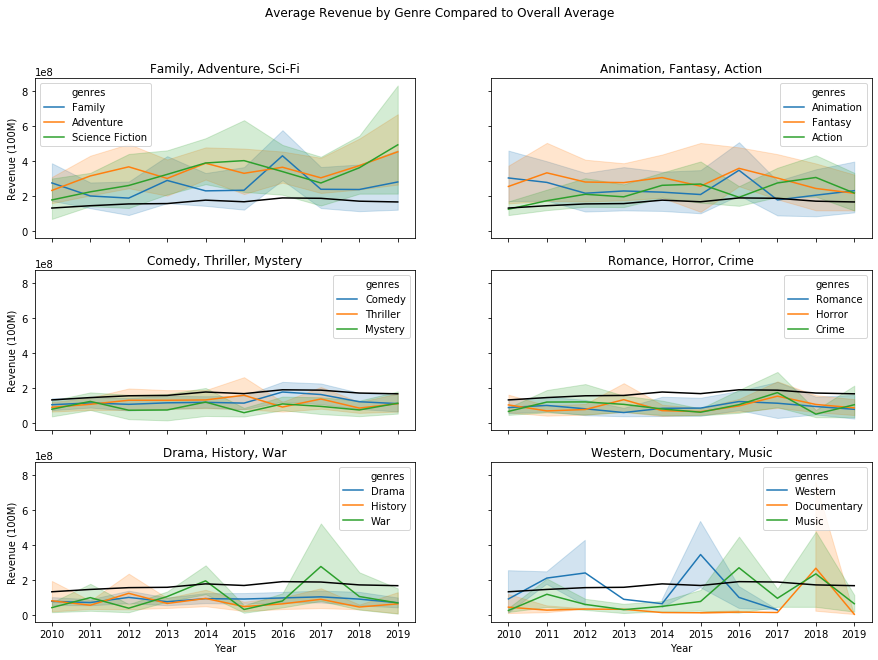

In [136]:
import seaborn as sns
fig, (ax1,ax2,ax3) = plt.subplots(3, 2, figsize=(15,10), sharex=True, sharey=True)

sns.lineplot(x='year', y='revenue', data=gen1_df, hue='genres', ax=ax1[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[0], color='black')
ax1[0].set_title('Family, Adventure, Sci-Fi')

sns.lineplot(x='year', y='revenue', data=gen2_df, hue='genres', ax=ax1[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax1[1], color='black')
ax1[1].set_title('Animation, Fantasy, Action')

sns.lineplot(x='year', y='revenue', data=gen3_df, hue='genres', ax=ax2[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[0], color='black')
ax2[0].set_title('Comedy, Thriller, Mystery')

sns.lineplot(x='year', y='revenue', data=gen4_df, hue='genres', ax=ax2[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax2[1], color='black')
ax2[1].set_title('Romance, Horror, Crime')

sns.lineplot(x='year', y='revenue', data=gen5_df, hue='genres', ax=ax3[0])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[0], color='black')
ax3[0].set_title('Drama, History, War')

sns.lineplot(x='year', y='revenue', data=gen6_df, hue='genres', ax=ax3[1])
sns.lineplot(data=genre_df.groupby('year').revenue.mean(), ax=ax3[1], color='black')
ax3[1].set_title('Western, Documentary, Music')

fig.suptitle("Average Revenue by Genre Compared to Overall Average")
ax3[0].set_xlabel("Year")
ax3[1].set_xlabel("Year")
ax1[0].set_ylabel("Revenue (100M)")
ax2[0].set_ylabel("Revenue (100M)")
ax3[0].set_ylabel("Revenue (100M)")

##### Here we can see that Family, Adventure, Sci-Fi, Animation, Fantasy, and Action all regularly perform better than average. Westerns, Documentaries, Music Movies, and War Movies are hit-or-miss from year-to-year, and the remaining genres regulary perform below the average.

#### Gathering information specific to 2019

In [94]:
year_19_df = genre_df[genre_df['year']=='2019'].sort_values('revenue', ascending=False)
year_19_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Adventure,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Action,2019,04-24,"[space travel, time travel, time machine, sequ..."
1795,299534,Avengers: Endgame,2797800564,356000000,"[Christopher Markus, Stephen McFeely]","[Anthony Russo, Joe Russo]",Science Fiction,2019,04-24,"[space travel, time travel, time machine, sequ..."
1796,420818,The Lion King,1656943394,260000000,[Jeff Nathanson],[Jon Favreau],Adventure,2019,07-12,"[africa, lion, prince, musical, uncle, remake,..."
1796,420818,The Lion King,1656943394,260000000,[Jeff Nathanson],[Jon Favreau],Family,2019,07-12,"[africa, lion, prince, musical, uncle, remake,..."
...,...,...,...,...,...,...,...,...,...,...
1993,547590,El Chicano,1370000,0,"[Joe Carnahan, Ben Hernandez Bray]",[Ben Hernandez Bray],Crime,2019,05-03,[]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Comedy,2019,06-05,[relationship]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Drama,2019,06-05,[relationship]
1994,608124,Chhalawa,1300000,0,[Wajahat Rauf],[Wajahat Rauf],Family,2019,06-05,[relationship]


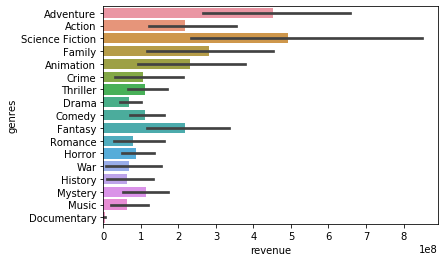

In [95]:
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres')

#### Gathering information specific to 2020

In [97]:
year_20_df = pd.DataFrame(columns=columns)
count = 1
page = 1
while page <= 10:
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key + \
      '&language=en-US&sort_by=revenue.desc&include_adult=false&include_video=false' + \
      '&primary_release_year=2020&page=' + str(page)
    year_2020 = requests.get(url)
    year_2020 = year_2020.json()
    results = year_2020['results']
    page += 1
    for film in results:
        print(count + ': ' + film['title'])
        count += 1
        try:
            film_rev = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +\
                                    '?api_key=' + api_key + '&language=en-US').json()
            crew = requests.get('https://api.themoviedb.org/3/movie/' + str(film['id']) +
                                    '/credits?api_key=' + api_key).json()  
            keywords = requests.get('https://api.themoviedb.org/3/movie/' +str(film['id']) +\
                                    '/keywords?api_key=' + api_key).json()
            details = [str(film['id']), film['title'], film_rev['revenue'], film_rev['budget'],\
                           [x['name'] for x in crew['crew'] if x['job']=='Screenplay' or (x['job']=='Writer')],\
                           [x['name'] for x in crew['crew'] if (x['job']=='Director')],\
                           [x['name'] for x in film_rev['genres']], film_rev['release_date'][:4],\
                           film_rev['release_date'][5:], [x['name'] for x in keywords['keywords']]]
            year_20_df.loc[len(year_20_df)]=details
        except:
            continue

Bad Boys for Life
Sonic the Hedgehog
Dolittle
Birds of Prey (and the Fantabulous Emancipation of One Harley Quinn)
The Invisible Man
The Gentlemen
The Call of the Wild
Onward
Scarlet Tulips
Fantasy Island
The Grudge
Underwater
Invasion
Ala Vaikunthapurramuloo
Bloodshot
Like a Boss
Emma.
Gretel & Hansel
Capone
Brahms: The Boy II
The Turning
The Way Back
Street Dancer 3D
Malang
UFC 246: McGregor vs. Cowboy
Impractical Jokers: The Movie
Nightlife
Downhill
The Hunt
My Spy
Varane Avashyamund
Lassie Come Home
Trolls World Tour
The Perfect Date
Block Z
The Elfkins - Baking a Difference
Sudakshinar Saree
I Love You, Stupid
ALL COPS AIN'T BAD
Mortal
Maceracı Yüzgeçler: Büyük Gösteri
The Mafia: Payback
Enter the Fat Dragon
Permette? Alberto Sordi
Boundary
Tokoloshe: An African Curse
The Passenger
Kabaddi Kabaddi Kabaddi
Resistance
Sí, Mi Amor
Moondance
Brothers
Detective Dee : Deep Sea Dragon Palace
Batman: Most Wanted
Mothman
Involuntary Solitude
Imitation
One Day
Glop
Carpe Diem
Live Periandro

In [99]:
year_20_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]","[Thriller, Action, Crime]",2020,01-15,"[detective, sequel, police officer, police det..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],"[Action, Science Fiction, Comedy, Family]",2020,02-12,"[video game, san francisco, california, friend..."
2,448119,Dolittle,223343452,175000000,"[Stephen Gaghan, Chris McKay, Thomas Shepherd]",[Stephen Gaghan],"[Comedy, Fantasy, Adventure, Family]",2020,01-01,"[based on novel or book, island, ship, victori..."
3,495764,Birds of Prey (and the Fantabulous Emancipatio...,201858461,75000000,[Christina Hodson],[Cathy Yan],"[Action, Crime, Comedy]",2020,02-05,"[dc comics, based on comic, woman director, dc..."
4,570670,The Invisible Man,123414678,9000000,[Leigh Whannell],[Leigh Whannell],"[Thriller, Science Fiction, Horror]",2020,02-26,"[based on novel or book, architect, pregnancy,..."
...,...,...,...,...,...,...,...,...,...,...
195,713225,大神猴3情劫篇,0,0,[],[Tam Chiu],"[Action, Fantasy]",2020,05-29,[]
196,713203,Alejandro & Miguel,0,0,[],[Joie Estrella Horwitz],[Documentary],2020,05-29,[]
197,713197,The Convergence of Souls,0,0,[],[Arun Konda],[Horror],2020,03-24,[]
198,713179,Waves (2020),0,0,[],[Gugu Seppi],[Horror],2020,07-09,[]


In [100]:
year_20_df.dtypes

id          object
title       object
revenue     object
budget      object
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Make 'budget' and 'revenue' numeric again

In [101]:
year_20_df['revenue'] = pd.to_numeric(year_20_df.revenue)
year_20_df['budget'] = pd.to_numeric(year_20_df.budget)

In [102]:
year_20_df.dtypes

id          object
title       object
revenue      int64
budget       int64
writer      object
director    object
genres      object
year        object
date        object
keywords    object
dtype: object

#### Only use films with revenue over 1M to keep data comparable to previous years

In [103]:
year_20_df = year_20_df[year_20_df.revenue.gt(1000000)]

In [104]:
year_20_df = year_20_df.explode('genres')

In [105]:
year_20_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Thriller,2020,01-15,"[detective, sequel, police officer, police det..."
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Action,2020,01-15,"[detective, sequel, police officer, police det..."
0,38700,Bad Boys for Life,419074646,90000000,"[Joe Carnahan, Peter Craig, Chris Bremner]","[Adil El Arbi, Bilall Fallah]",Crime,2020,01-15,"[detective, sequel, police officer, police det..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],Action,2020,02-12,"[video game, san francisco, california, friend..."
1,454626,Sonic the Hedgehog,306766470,85000000,"[Josh Miller, Patrick Casey]",[Jeff Fowler],Science Fiction,2020,02-12,"[video game, san francisco, california, friend..."
...,...,...,...,...,...,...,...,...,...,...
32,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Family,2020,03-12,"[sequel, based on toy]"
32,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Comedy,2020,03-12,"[sequel, based on toy]"
32,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Fantasy,2020,03-12,"[sequel, based on toy]"
32,446893,Trolls World Tour,1946164,0,"[Wallace Wolodarsky, Glenn Berger, Jonathan Ai...",[Walt Dohrn],Adventure,2020,03-12,"[sequel, based on toy]"


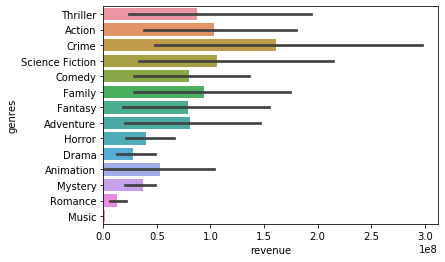

In [106]:
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres')

#### Plot to compare average revenue by genre from 2019 to 2020 so far

Text(0.5, 0.98, 'Average Revenues by Genre in 2019, 2020')

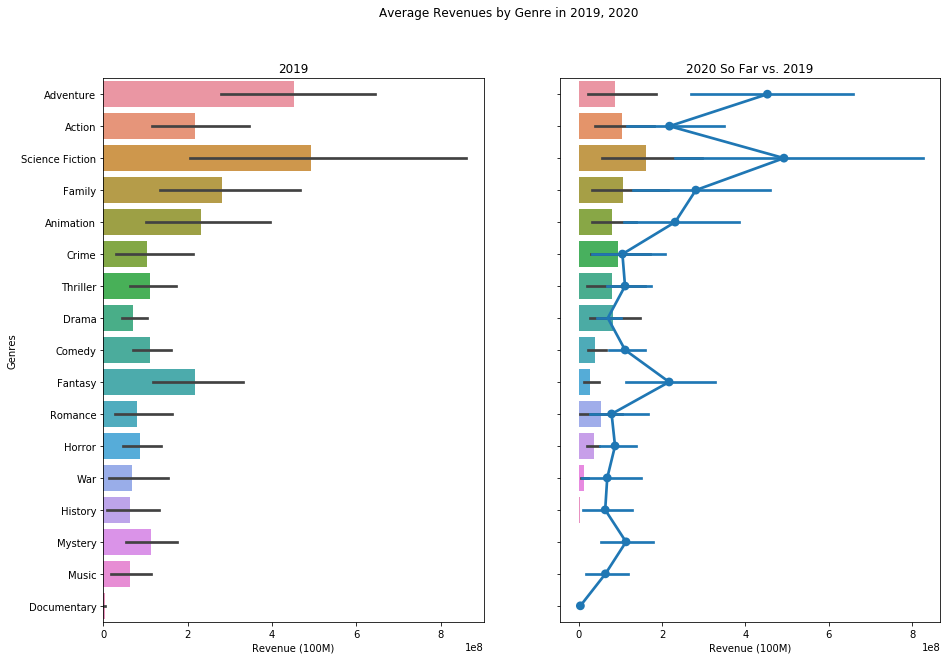

In [107]:
fig, ax1 = plt.subplots(1, 2, figsize=(15,10), sharey=True)
sns.barplot(orient='h', data=year_19_df, x='revenue', y='genres', ax=ax1[0])
ax1[0].set_title("2019")
ax1[0].set_xlabel("Revenue (100M)")
ax1[0].set_ylabel('Genres')
sns.barplot(orient='h', data=year_20_df, x='revenue', y='genres', ax=ax1[1])
sns.pointplot(data=year_19_df, x='revenue', y='genres', ax=ax1[1])
ax1[1].set_title('2020 So Far vs. 2019')
ax1[1].set_xlabel('Revenue (100M)')
ax1[1].set_ylabel("")
fig.suptitle("Average Revenues by Genre in 2019, 2020")

## Who are the top writers for the top genres, and how much revenue do their movies pull?

In [108]:
best_genres_df = genre_df[(genre_df.genres.isin(gen1))|(genre_df.genres.isin(gen2))]
best_genres_df

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],Animation,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],Family,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],Family,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],Fantasy,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],Adventure,2010,03-03,"[based on novel or book, queen, fantasy world,..."
...,...,...,...,...,...,...,...,...,...,...
1987,639251,Kral Şakir: Korsanlar Diyarı,1579078,0,[],"[Haluk Can Dizdaroglu, Berk Tokay]",Animation,2019,10-04,[]
1987,639251,Kral Şakir: Korsanlar Diyarı,1579078,0,[],"[Haluk Can Dizdaroglu, Berk Tokay]",Adventure,2019,10-04,[]
1989,659153,5Gang: A Different Kind of Christmas,1489573,1500000,[Matei Dima],[Matei Dima],Action,2019,12-27,[music band]
1993,547590,El Chicano,1370000,0,"[Joe Carnahan, Ben Hernandez Bray]",[Ben Hernandez Bray],Action,2019,05-03,[]


In [109]:
writers_df = best_genres_df.drop(columns=['genres', 'director', 'keywords'])

In [110]:
writers_df = writers_df.explode('writer')
writers_df = writers_df.drop_duplicates()

In [111]:
writers_df.duplicated().sum()

0

In [112]:
writers_plot = writers_df.groupby(['writer']).mean().sort_values(['revenue'], ascending=False).head(30)

Text(0, 0.5, '')

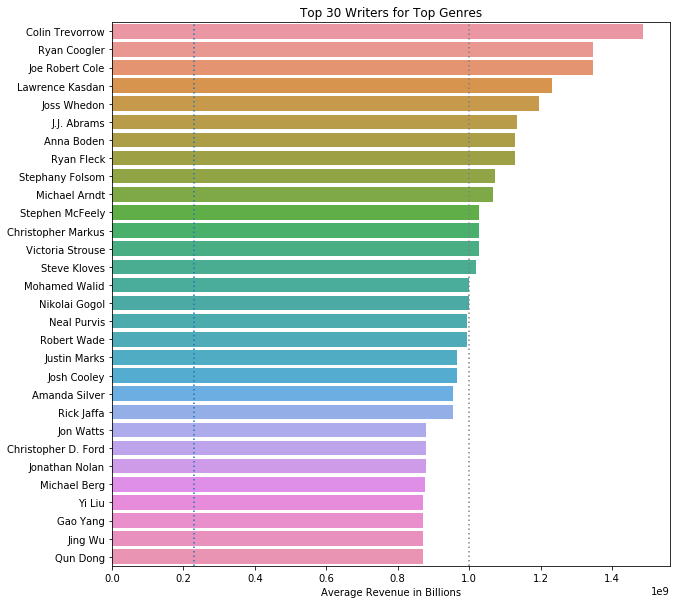

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=writers_plot, x='revenue', y=writers_plot.index, orient='h', ax=ax)
plt.axvline(x=writers_df.revenue.mean(), dashes=(1,2))
plt.axvline(x=1000000000, c='grey', dashes=(1,2))
plt.title('Top 30 Writers for Top Genres')
plt.xlabel('Average Revenue in Billions')
plt.ylabel('')

## What keywords describe the best-performing movies?

We plot the frequency with which keywords are used to describe movies that perform above the average mark.

In [118]:
keywords_df = best_genres_df.drop(columns=['writer', 'director', 'genres'])
keywords_df.head()

,id,title,revenue,budget,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
0,10193,Toy Story 3,1066969703,200000000,2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."
1,12155,Alice in Wonderland,1025467110,200000000,2010,03-03,"[based on novel or book, queen, fantasy world,..."


In [120]:
keywords_df = keywords_df.explode('keywords')

In [121]:
keywords_df = keywords_df.drop_duplicates()

In [122]:
keywords_df = keywords_df.dropna()
len(keywords_df)

7797

In [123]:
keywords_df = keywords_df[keywords_df.revenue.gt(df.revenue.mean())]
len(keywords_df)

3850

In [124]:
keywords_plot = keywords_df.keywords.value_counts()[:30]
keywords_plot

duringcreditsstinger          72
sequel                        69
3d                            69
aftercreditsstinger           53
based on comic                52
based on novel or book        46
superhero                     45
dystopia                      36
based on young adult novel    25
magic                         23
marvel cinematic universe     22
anthropomorphism              21
super power                   20
alien                         18
remake                        17
imax                          17
good vs evil                  16
spacecraft                    16
friendship                    14
robot                         14
future                        14
spy                           14
new york city                 14
revenge                       13
space                         13
family                        12
musical                       11
violence                      11
spin off                      11
female protagonist            11
Name: keyw

In [150]:
keywords_plot = pd.DataFrame(keywords_plot).reset_index()

In [152]:
keywords_plot

,index,keywords
0,duringcreditsstinger,72
1,sequel,69
2,3d,69
3,aftercreditsstinger,53
4,based on comic,52
5,based on novel or book,46
6,superhero,45
7,dystopia,36
8,based on young adult novel,25
9,magic,23


Text(0, 0.5, 'Keywords')

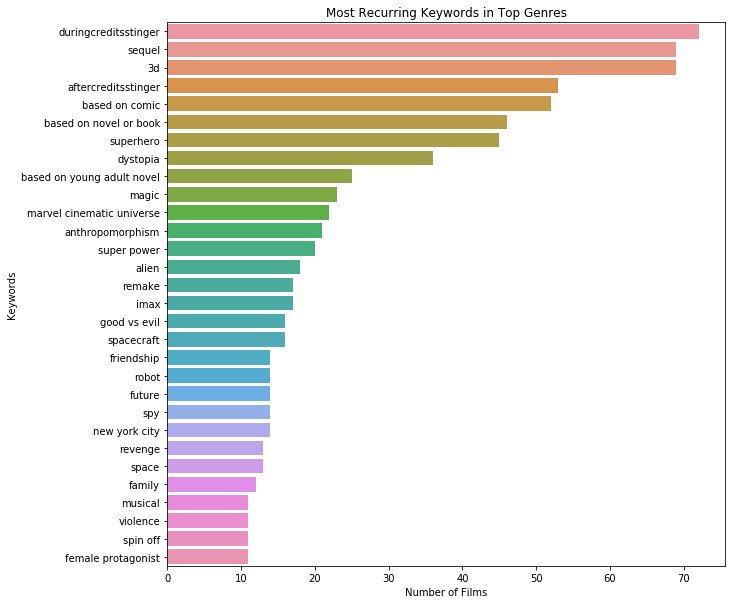

In [159]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=keywords_plot, orient='h', x='keywords', y='index', ax=ax)
plt.title('Most Recurring Keywords in Top Genres')
plt.xlabel('Number of Films')
plt.ylabel('Keywords')

##### Obviously, there are some here that we can't use, like 'sequel' or 'marvel cinematic universe.' It stands to reason, though, that a movie left open for a sequel is a good investment. Also, movies based on books and comics seem to do well.

## What is the effect of release date on expected revenue?

In [126]:
df.head()

,id,title,revenue,budget,writer,director,genres,year,date,keywords
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy..."
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,..."
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport..."
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego..."
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]"


#### Getting the month from the date column

In [127]:
df['month'] = [[x][0][:2] for x in df['date']]
df.head()

,id,title,revenue,budget,writer,director,genres,year,date,keywords,month
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy...",06
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,...",03
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport...",10
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego...",07
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]",05


#### Using month to determine quarter

In [128]:
import math
df['quarter'] = [math.ceil(int(x)/3) for x in df['month']]
df

,id,title,revenue,budget,writer,director,genres,year,date,keywords,month,quarter
0,10193,Toy Story 3,1066969703,200000000,[Michael Arndt],[Lee Unkrich],"[Animation, Family, Comedy]",2010,06-16,"[hostage, college, toy, escape, daycare, teddy...",06,2
1,12155,Alice in Wonderland,1025467110,200000000,[Linda Woolverton],[Tim Burton],"[Family, Fantasy, Adventure]",2010,03-03,"[based on novel or book, queen, fantasy world,...",03,1
2,12444,Harry Potter and the Deathly Hallows: Part 1,954305868,250000000,[Steve Kloves],[David Yates],"[Adventure, Fantasy]",2010,10-17,"[corruption, isolation, radio, magic, teleport...",10,4
3,27205,Inception,825532764,160000000,[Christopher Nolan],[Christopher Nolan],"[Action, Science Fiction, Adventure]",2010,07-15,"[paris, france, spy, philosophy, hotel, allego...",07,3
4,10192,Shrek Forever After,752600867,165000000,"[Josh Klausner, Darren Lemke, Alejandro Bien-W...",[Mike Mitchell],"[Comedy, Adventure, Fantasy, Animation, Family]",2010,05-16,"[ogre, 3d]",05,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1990,679106,Stanley H.,1407457,2500000,"[Robert Jan Overeem, Jan Harm Dekker]",[Tim Oliehoek],"[Crime, Drama, History]",2019,10-13,[],10,4
1991,585973,"One Love , Two Lives",1401422,0,"[Özlem Yilmaz, Burcu Görgün Toptaş]",[Ali Bilgin],"[Drama, Romance]",2019,02-15,[],02,1
1992,607586,Wrong No. 2,1400000,0,"[Yasir Nawaz, Mohsin Ali, Danish Nawaz]",[Yasir Nawaz],"[Romance, Comedy]",2019,06-05,"[pakistan, slapstick, romance, wedding, comedy...",06,2
1993,547590,El Chicano,1370000,0,"[Joe Carnahan, Ben Hernandez Bray]",[Ben Hernandez Bray],"[Drama, Action, Crime]",2019,05-03,[],05,2


#### Plot by quarter for 2010-2019

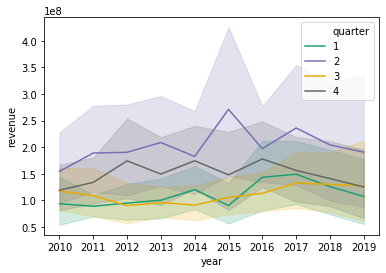

In [129]:
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2')

#### find release quarters for 2020

In [130]:
year_20_df['month'] = [[x][0][:2] for x in year_20_df['date']]
year_20_df['quarter'] = [math.ceil(int(x)/3) for x in year_20_df['month']]
year_20_df.groupby('quarter').count()

,id,title,revenue,budget,writer,director,genres,year,date,keywords,month
quarter,,,,,,,,,,,
1,89,89,89,89,89,89,88,89,89,89,89
2,2,2,2,2,2,2,2,2,2,2,2


#### Plot 2020 by month since there are only 2 quarters to show

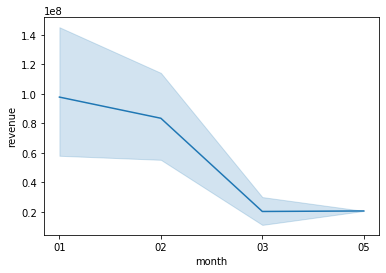

In [132]:
sns.lineplot(data=year_20_df, x='month', y='revenue')

#### Show plot comparing past years quarterly to this year

Text(0.5, 0.98, 'A Comparison of Revenue by Release Schedule')

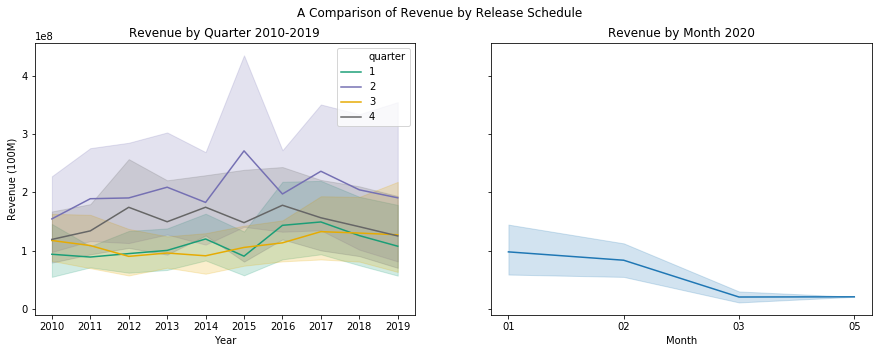

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
sns.lineplot(data=df, x='year', y='revenue', hue='quarter', palette='Dark2', ax=axes[0])
sns.lineplot(data=year_20_df, x='month', y='revenue', ax=axes[1])
axes[0].set_title('Revenue by Quarter 2010-2019')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Revenue (100M)')
axes[1].set_title('Revenue by Month 2020')
axes[1].set_xlabel('Month')
fig.suptitle("A Comparison of Revenue by Release Schedule")

##### Here we can see that we can expect a bump in revenue in quarters 2 and 4. So, the best time to release our film is in the summer or during the holiday season. 2020 has not gotten its quarter 2 bump, presumably due to Covid-19 restrictions.

### Recommendation: Big budget Sci-Fi/Adventure film to (based on popular book or comic series) release in summer or the holiday season. Revenues are currently below expectations due to Covid-19, but we can expect that slump to be over before the film finishes production. Starting a film franchise is a good investment for revenue in the future.